# Modeling Crop Yield

In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

## Parameters

In [2]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2-l2a"
bands = "2-3-4"
country_code = "ZMB"
points = "15"
num_features = "1000"
feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}'
                     f'k-points_{num_features}-features')

weight_file_name = (f'{country_code}_crop_weights{points}k-points')

## Boundaries 

In [3]:
country_shp = geopandas.read_file(f'/capstone/cropmosaiks/data/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# country_shp

(72, 1)

## Crops

In [4]:
crop_df = pd.read_csv('/capstone/cropmosaiks/data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
crop_df = crop_df.set_index('district')
# crop_df

In [5]:
list(set(crop_districts) - set(country_districts))

['Ikelenge', 'Mafinga']

In [6]:
list(set(country_districts) - set(crop_districts))

[]

In [7]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Weights

In [8]:
# weights = pd.read_feather(f"data/weights/{weight_file_name}_2018.feather")
# weights.crop_perc = weights.crop_perc.fillna(0)
# weights.crop_perc = weights.crop_perc + 0.0001
# weights

In [9]:
# weights_gdf.plot(figsize = (15,15),
                 # cmap = 'inferno',
                 # cmap = new_cmap,
                 # markersize = 3,
                 # alpha = .9,
                 # column = 'crop_perc')
# plt.axis('off')

In [11]:
features_raw = geopandas.GeoDataFrame()
year_start = 2015
year_end = 2018

for yr in range(year_start, year_end + 1):
    print("Opening:", yr)
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather")
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_raw = pd.concat([features_raw, features_x], axis=0)
    
    print("feature.shape", features_raw.shape)
    print("Appending:", yr)
    print("")

Opening: 2015
feature.shape (22141, 1004)
Appending: 2015

Opening: 2016
feature.shape (158145, 1004)
Appending: 2016

Opening: 2017
feature.shape (274943, 1004)
Appending: 2017

Opening: 2018
feature.shape (423933, 1004)
Appending: 2018



In [17]:
features = features_raw.copy()

features['year_shift'] = np.where(
    features['month'].isin([7, 8, 9, 10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year_shift'] <= year_end]


,0,1,2,3,4,5,6,7,8,9,...,995,996,997,998,999,lon,lat,year,month,year_shift
0,2.860263,0.343474,0.008509,0.0,0.000165,0.000763,0.038653,0.001599,0.883490,0.0,...,0.934016,2.664612,1.535779,0.270975,0.142968,27.631717,-16.328476,2015,7,2016
1,3.080723,0.469075,0.012040,0.0,0.000226,0.001981,0.076759,0.002713,0.865638,0.0,...,0.997131,2.669617,1.540072,0.174514,0.060316,27.678368,-16.283133,2015,7,2016
2,2.367531,0.174048,0.005804,0.0,0.000000,0.000121,0.008685,0.000316,0.680263,0.0,...,0.920017,2.476734,1.471943,0.385269,0.255571,27.725330,-16.328175,2015,7,2016
3,2.063190,0.098082,0.005961,0.0,0.000000,0.000170,0.005788,0.000515,0.596611,0.0,...,0.890967,2.404461,1.455726,0.465969,0.378454,27.771959,-16.282812,2015,7,2016
4,3.663002,0.627585,0.012534,0.0,0.000171,0.002152,0.125511,0.002470,1.162754,0.0,...,0.981800,2.950739,1.645751,0.088018,0.029338,27.724998,-16.237780,2015,7,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148985,2.137589,0.070637,0.001742,0.0,0.000850,0.000270,0.008894,0.000520,0.728735,0.0,...,0.842729,2.580128,1.567490,0.416812,0.421966,30.285618,-15.536390,2018,12,2019
148986,2.960216,0.281543,0.000907,0.0,0.001587,0.000080,0.054446,0.001598,1.039274,0.0,...,0.898354,2.876995,1.678693,0.188419,0.188409,30.332893,-15.580818,2018,12,2019
148987,3.191839,0.367929,0.000012,0.0,0.007295,0.000000,0.065688,0.000187,1.048186,0.0,...,0.933584,2.877813,1.673973,0.142543,0.089179,30.379994,-15.625335,2018,12,2019
148988,2.018795,0.022460,0.000000,0.0,0.001049,0.000000,0.001405,0.000001,0.759700,0.0,...,0.812807,2.624252,1.624895,0.398391,0.496921,30.286859,-15.626751,2018,12,2019


In [21]:

features

,0,1,2,3,4,5,6,7,8,9,...,995,996,997,998,999,lon,lat,year,month,year_shift
0,2.860263,0.343474,0.008509,0.0,0.000165,0.000763,0.038653,0.001599,0.883490,0.0,...,0.934016,2.664612,1.535779,0.270975,0.142968,27.631717,-16.328476,2015,7,2016
1,3.080723,0.469075,0.012040,0.0,0.000226,0.001981,0.076759,0.002713,0.865638,0.0,...,0.997131,2.669617,1.540072,0.174514,0.060316,27.678368,-16.283133,2015,7,2016
2,2.367531,0.174048,0.005804,0.0,0.000000,0.000121,0.008685,0.000316,0.680263,0.0,...,0.920017,2.476734,1.471943,0.385269,0.255571,27.725330,-16.328175,2015,7,2016
3,2.063190,0.098082,0.005961,0.0,0.000000,0.000170,0.005788,0.000515,0.596611,0.0,...,0.890967,2.404461,1.455726,0.465969,0.378454,27.771959,-16.282812,2015,7,2016
4,3.663002,0.627585,0.012534,0.0,0.000171,0.002152,0.125511,0.002470,1.162754,0.0,...,0.981800,2.950739,1.645751,0.088018,0.029338,27.724998,-16.237780,2015,7,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69172,0.316429,0.015503,0.000047,0.0,0.000278,0.000067,0.003550,0.000020,0.055474,0.0,...,0.892430,1.589772,1.213868,0.870158,0.917146,27.961818,-16.824366,2018,6,2018
69173,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.887298,1.279622,1.079554,1.070847,1.101043,27.915112,-16.869773,2018,6,2018
69174,0.279700,0.016879,0.000560,0.0,0.000272,0.000149,0.003259,0.000114,0.050571,0.0,...,0.883252,1.565579,1.201185,0.901819,0.941217,27.867971,-16.824784,2018,6,2018
69175,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.875690,1.329423,1.100723,1.061020,1.101449,27.821241,-16.870170,2018,6,2018


## Features

In [10]:
features = geopandas.GeoDataFrame()
year_start = 2016
year_end = 2018
for yr in range(year_start, year_end + 1):
    print("Opening:", yr)
    print(f"File: {feature_file_name}_{yr}.feather")
    # Read in the file
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather") 
    # Force years to span the growing season which for Zambia is November to May
    features_x['year'] = np.where(
        features_x['month'].isin(["07", "08", "09", "10", "11", "12"]),
        features_x['year'] + 1, 
        features_x['year']
    ) 
    # The above step makes the ending months of the final dataset to be outside the desired date range
    # Below we get rid of unwanted months by filtering for years in the daterange
    features_x = features_x[features_x['year'] < year_end + 1]
    
    # Here we pivot the data from long format to wide by indexing on 
    # 'lon','lat', "year", 'month' and using the unstack function
    features_x = features_x.set_index(['lon','lat', "year", 'month']).unstack()
    # We then map column names based on the month index and the associated features
    # so month '01' is appended to each feature for that month making 0_01, 1_01 etc. 
    features_x.columns = features_x.columns.map(lambda x: '{}_{}'.format(*x))
    # The index is then reset
    features_x = features_x.reset_index()
    
    # We then make the resulting wide data into a GeoDataFrame
    features_x = geopandas.GeoDataFrame(
        features_x, 
        geometry = geopandas.points_from_xy(x = features_x.lon, y = features_x.lat)
        , crs='EPSG:4326'
    )#.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat']) # Optionally attach weight to each point (% area cropped of surrounding 1 km^2)
    # Drop lon and lat now that they are in geometry column
    features_x = features_x.drop(['lon', 'lat'], axis = 1)
    
    # Join features to crop data with a spatial join
    print("Joining:", yr)
    country_x = country_crop[country_crop.year == yr]
    adm_features = features_x.sjoin(country_x, how = 'left', predicate = 'within')
    
    # Concatenate the joined data into a single GeoDataFrame while looping through years 
    print("Appending:", yr)
    features = geopandas.GeoDataFrame(
        pd.concat([features, adm_features], axis = 0), #, ignore_index=True),
        crs = 'EPSG:4326'
    ).reset_index(drop = True)
    print("features.shape:", features.shape)
    print("")

Opening: 2016
File: sentinel-2_ZMB_15k-points_1000-features_2016.feather
Joining: 2016
Appending: 2016
features.shape: (30102, 12005)

Opening: 2017
File: sentinel-2_ZMB_15k-points_1000-features_2017.feather
Joining: 2017
Appending: 2017
features.shape: (60218, 12005)

Opening: 2018
File: sentinel-2_ZMB_15k-points_1000-features_2018.feather
Joining: 2018
Appending: 2018
features.shape: (75276, 12005)



In [11]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features = (
    features
    .dropna(subset=['index_right'])
    .drop(['year_right'], axis = 1)
    .rename(columns = {
        "index_right": "district", 
        "year_left": "year"})
    .reset_index(drop = True)
)
features_gdf = features.copy()
features = features.drop(['geometry'], axis = 1)

In [13]:
impute_data = True
# impute_data = False

if impute_data:
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    features = features.set_index(['district', 'year', 'yield_mt',])
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()
else:
    features = features.fillna(0)

In [14]:
# features_croppped = features[features.crop_perc > 0]
# features.shape

In [15]:
# if satellite == "landsat-8-c2-l2":
#     na = features[features.isna().any(axis = 1)]
#     na.plot(figsize = (15,15), markersize = 1)
#     # plt.savefig(f'images/nans.jpg', dpi=300)
#     features = features.dropna()

In [16]:
# features_summary = features.groupby(['district', 'yield_mt' ,"year"], as_index = False
#                                    ).apply(lambda x: np.average(x['0'], weights=x['crop_perc'], axis = 0))
# features_summary

In [17]:
features_summary = features.groupby(['district',"year"], as_index = False).mean()

In [18]:
features_summary

,district,year,yield_mt,0_01,0_02,0_03,0_04,0_05,0_06,0_07,...,999_03,999_04,999_05,999_06,999_07,999_08,999_09,999_10,999_11,999_12
0,Chadiza,2016,1.876427,0.000004,0.000002,0.000004,0.000000e+00,2.968268e-06,4.449600e-06,0.000002,...,0.241054,0.975665,0.130139,0.114329,0.225347,0.058394,0.020167,0.030108,0.053415,0.205191
1,Chadiza,2017,2.379687,0.000004,0.000002,0.000002,1.731456e-06,1.178588e-06,1.252046e-06,0.000001,...,0.463499,0.362148,0.319147,0.259755,0.117402,0.037371,0.012607,0.017224,0.029349,0.200903
2,Chadiza,2018,2.091113,0.000003,0.000002,0.000002,1.109501e-06,1.542198e-06,2.258453e-06,0.000001,...,0.462439,0.359891,0.320985,0.243156,0.181698,0.049189,0.012679,0.017379,0.039255,0.204508
3,Chama,2016,1.257456,0.000004,0.000002,0.000001,1.270917e-06,1.040674e-06,1.505762e-06,0.000002,...,0.441086,0.570170,0.351190,0.215821,0.225347,0.058394,0.020167,0.030108,0.053415,0.205191
4,Chama,2017,1.782732,0.000004,0.000002,0.000002,1.638383e-06,1.679695e-06,1.510546e-06,0.000001,...,0.463499,0.453080,0.395903,0.288228,0.161191,0.045930,0.015527,0.018663,0.034661,0.221376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Solwezi,2017,1.347232,0.000004,0.000002,0.000002,1.737911e-06,1.364656e-06,1.601602e-06,0.000002,...,0.463739,0.490458,0.431340,0.374841,0.462273,0.082085,0.029622,0.073797,0.086577,0.209995
212,Solwezi,2018,1.514096,0.000004,0.000001,0.000002,9.447959e-07,1.083939e-06,1.657523e-06,0.000001,...,0.488457,0.500169,0.444760,0.372014,0.232052,0.077804,0.022183,0.066079,0.117734,0.205191
213,Zambezi,2016,1.725293,0.000003,0.000001,0.000002,5.250395e-07,6.091690e-07,5.656485e-07,0.000002,...,0.463499,0.691969,0.543863,0.365650,0.225347,0.058394,0.020167,0.030108,0.053415,0.205191
214,Zambezi,2017,1.607874,0.000004,0.000002,0.000001,9.073661e-07,1.500243e-06,1.082880e-06,0.000001,...,0.452557,0.458489,0.374126,0.301653,0.246142,0.062311,0.021113,0.030304,0.050172,0.184143


## Model

In [19]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [21]:
len(y_all)

216

In [22]:
len(x_train)

172

In [23]:
len(x_test)

44

In [24]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [25]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.23


In [26]:
# y_pred = np.maximum(ridge_cv_random.predict(x_all), 0)

# plt.figure()
# plt.scatter(y_pred, y_all, alpha=1, s=4)
# plt.xlabel("Predicted", fontsize=15)
# plt.ylabel("Ground Truth", fontsize=15)
# plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
# plt.title(f"Model applied to all data n = {len(x_all)}, R$^2$ = {(r2_score(y_all, y_pred)):0.2f}",
#           fontsize=12, y=1)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.text(0.1, .75,
#          s="R$^2$ = %0.2f" % (r2_score(y_all, y_pred)),
#          fontsize=15, fontweight="bold")

# m, b = np.polyfit(y_pred, y_all, 1)
# plt.plot(y_pred, m * y_pred + b, color="black")
# plt.gca().spines.right.set_visible(False)
# plt.gca().spines.top.set_visible(False)

# plt.show()
# plt.close()

In [27]:
# spearmanr(y_pred, y_all)

In [28]:
# pearsonr(y_pred, y_all)

In [29]:
# spearmanr(y_pred, y_all)

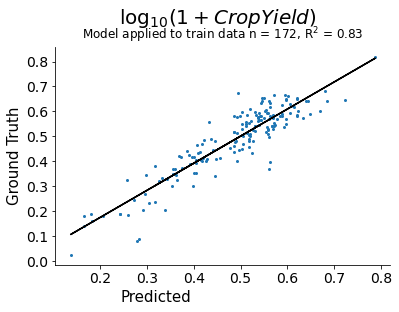

In [30]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [31]:
r2_score(y_train, y_pred)

0.8316179911509347

In [32]:
pearsonr(y_pred, y_train)

(0.9146210028629148, 9.251720587217649e-69)

In [33]:
spearmanr(y_pred, y_train)

SpearmanrResult(correlation=0.8577883746872221, pvalue=5.1994660630894733e-51)

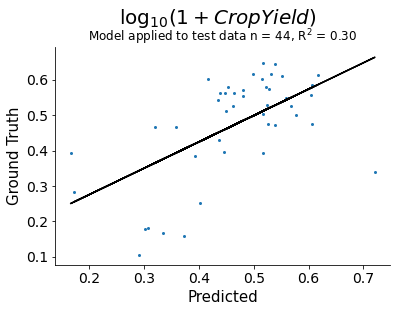

In [34]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [35]:
r2_score(y_test, y_pred)

0.29702091453834134

In [36]:
pearsonr(y_pred, y_test)

(0.5825714256566676, 3.3398141875105415e-05)

In [37]:
spearmanr(y_pred, y_test)

SpearmanrResult(correlation=0.5389711064129669, pvalue=0.00016023762176365042)

In [38]:
pred_features = features.copy()
pred_features['geometry'] = features_gdf['geometry']
pred_features = geopandas.GeoDataFrame(pred_features)
x_all = pred_features.drop(['year', 'district', 'geometry', 'yield_mt'], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [39]:
plot_features = pred_features[pred_features.year == 2018]
# plot_features

<AxesSubplot:>

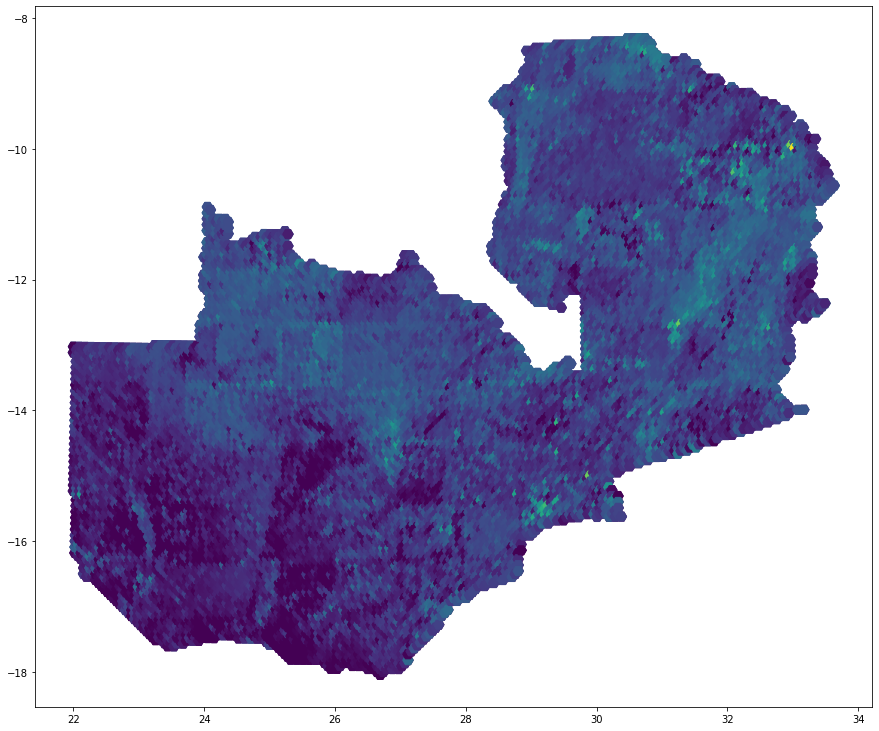

In [40]:
plot_features.plot(figsize = (15,15),
                   marker='H',
                   # legend = True,
                   markersize = 110,
#                    alpha = .9,
                   column = 'fit')

In [41]:
# this is a comment

## Plot Residuals

In [42]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

residual_df = pd.DataFrame()

residual_df["yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["yield"] - residual_df["prediction"]
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
residual_gdf = geopandas.GeoDataFrame(residual_df)

Text(0.5, 1.0, '2016 Residuals')

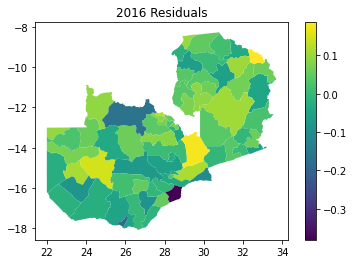

In [43]:
year = 2016
residual_gdf[residual_gdf.year == year].plot(column = "residual", legend = True)
plt.title(f"{year} Residuals")

Text(0.5, 1.0, '2017 Residuals')

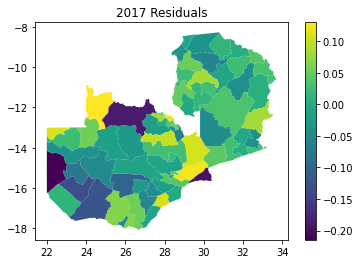

In [44]:
year = 2017
residual_gdf[residual_gdf.year == year].plot(column = "residual", legend = True)
plt.title(f"{year} Residuals")

Text(0.5, 1.0, '2018 Residuals')

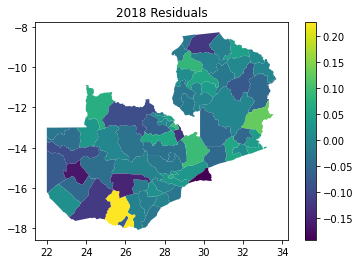

In [45]:
year = 2018
residual_gdf[residual_gdf.year == year].plot(column = "residual", legend = True)
plt.title(f"{year} Residuals")